## Data Exploration And Use Case Overview :

The objective of this notebook is to predict if a passager survived the titanic crash


**Features for Model Training**: Useful variables related to the survival

**Target to Predict**: Categorical variable that indicates if the person survived 


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

# 1 - Load data

In [4]:
DATA_FOLDER = "../data"

train_df = pd.read_csv(DATA_FOLDER + '/train_and_test2.csv')

In [5]:
train_df.head()

,Passengerid,Age,Fare,Sex,sibsp,zero,zero.1,zero.2,zero.3,zero.4,...,zero.12,zero.13,zero.14,Pclass,zero.15,zero.16,Embarked,zero.17,zero.18,2urvived
0,1,22.0,7.2500,0,1,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0
1,2,38.0,71.2833,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0.0,0,0,1
2,3,26.0,7.9250,1,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,1
3,4,35.0,53.1000,1,1,0,0,0,0,0,...,0,0,0,1,0,0,2.0,0,0,1
4,5,35.0,8.0500,0,0,0,0,0,0,0,...,0,0,0,3,0,0,2.0,0,0,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passengerid  1309 non-null   int64  
 1   Age          1309 non-null   float64
 2   Fare         1309 non-null   float64
 3   Sex          1309 non-null   int64  
 4   sibsp        1309 non-null   int64  
 5   zero         1309 non-null   int64  
 6   zero.1       1309 non-null   int64  
 7   zero.2       1309 non-null   int64  
 8   zero.3       1309 non-null   int64  
 9   zero.4       1309 non-null   int64  
 10  zero.5       1309 non-null   int64  
 11  zero.6       1309 non-null   int64  
 12  Parch        1309 non-null   int64  
 13  zero.7       1309 non-null   int64  
 14  zero.8       1309 non-null   int64  
 15  zero.9       1309 non-null   int64  
 16  zero.10      1309 non-null   int64  
 17  zero.11      1309 non-null   int64  
 18  zero.12      1309 non-null   int64  
 19  zero.1

In [7]:
train_df.isnull().sum()

Passengerid    0
Age            0
Fare           0
Sex            0
sibsp          0
zero           0
zero.1         0
zero.2         0
zero.3         0
zero.4         0
zero.5         0
zero.6         0
Parch          0
zero.7         0
zero.8         0
zero.9         0
zero.10        0
zero.11        0
zero.12        0
zero.13        0
zero.14        0
Pclass         0
zero.15        0
zero.16        0
Embarked       2
zero.17        0
zero.18        0
2urvived       0
dtype: int64

# 2 - Prepare the data

## 2-1 Clean Data

In [8]:
selected_cols = ['Age', 'Fare', 'Sex', 'sibsp', 'Parch', 'Pclass', 'Embarked', '2urvived']
train_df = train_df[selected_cols]

In [9]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1307 non-null   float64
 1   Fare      1307 non-null   float64
 2   Sex       1307 non-null   int64  
 3   sibsp     1307 non-null   int64  
 4   Parch     1307 non-null   int64  
 5   Pclass    1307 non-null   int64  
 6   Embarked  1307 non-null   float64
 7   2urvived  1307 non-null   int64  
dtypes: float64(3), int64(5)
memory usage: 91.9 KB


We can visualise how the taarget is distributed : 

In [10]:
train_df["2urvived"].value_counts()

2urvived
0    967
1    340
Name: count, dtype: int64

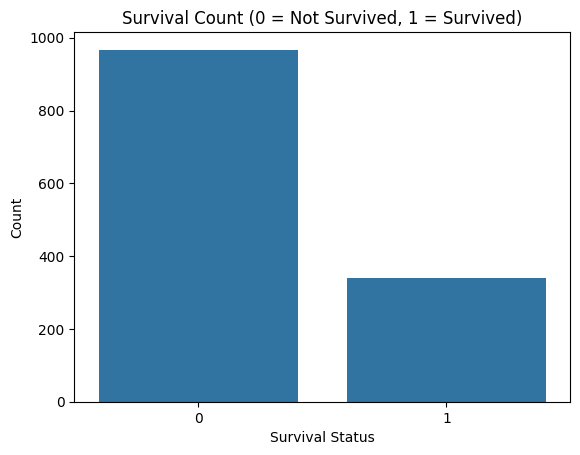

In [13]:
# Plot the distribution of the "Survived" column, showing the two values: 0 and 1.
sns.countplot(x=train_df["2urvived"])

# Add title and labels
plt.title("Survival Count (0 = Not Survived, 1 = Survived)")
plt.xlabel("Survival Status")
plt.ylabel("Count")

# Show the plot
plt.show()

## 2-2 Prepare features

In [14]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df = pd.DataFrame(train_df)
test_df = pd.DataFrame(test_df)

### 2-2-1 Categorical features

In [15]:
CATEGORICAL_COLS = ['Pclass', 'Sex', 'Embarked']

def encode_categorical_cols(df):
    label_encoders = {}
    for col in CATEGORICAL_COLS:
        df[col] = df[col].fillna("Unknown")
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    
    return df, label_encoders

train_df, encoders = encode_categorical_cols(train_df)

In [16]:
def extract_x_y(df, categorical_cols=None, dv=None, with_target=True):
    if categorical_cols is None:
        categorical_cols = ['Pclass', 'Sex', 'Embarked']
    
    dicts = df[categorical_cols].to_dict(orient="records")
    y = None

    if with_target:
        if dv is None:
            dv = DictVectorizer()
            dv.fit(dicts)
        y = df["2urvived"].values

    x = dv.transform(dicts)
    return x, y, dv

X_train, y_train, dv = extract_x_y(train_df)

# 3 - Train model

In [17]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [18]:
model_lg = LogisticRegression(random_state=1, max_iter=1000)
model_lg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=1)

# 4 - Evaluate model

In [19]:
def compute_metrics(y, y_pred):
    metrics = {
        "accuracy": accuracy_score(y, y_pred),
    }
    return metrics

## 4-1 On train data

In [20]:
y_pred_rf = model_rf.predict(X_train)
y_pred_lg = model_lg.predict(X_train)
compute_metrics(y_train, y_pred_rf), compute_metrics(y_train, y_pred_lg)

({'accuracy': 0.7961722488038278}, {'accuracy': 0.7741626794258373})

## 4-2 On test data

In [21]:
def transform_categorical_cols(df, encoders):
    for col, encoder in encoders.items():
        df[col] = df[col].fillna("Unknown")
        df[col] = encoder.transform(df[col])
    return df

test_df = transform_categorical_cols(test_df, encoders)
X_test, y_test, _ = extract_x_y(test_df, dv=dv)

In [22]:
y_pred_test_rf = model_rf.predict(X_test)
y_pred_test_lg = model_lg.predict(X_test)
compute_metrics(y_test, y_pred_test_rf), compute_metrics(y_test, y_pred_test_lg)

({'accuracy': 0.7786259541984732}, {'accuracy': 0.7595419847328244})